### 實驗內容描述:
下載kaggle上中風的資料集，利用各種分類器進行訓練並評估成效
###實驗結果:
分類器<br/>

1. TensorFlow類神經網路
2. TensorFlow BoostedTreeClassifier
3. sklearn DecisionTreeClassifier
4. sklearn BoostedTreeClassifier
5. sklearn RandomForestClassifier
6. sklearn kNNClassifier

資料解釋<br/>
1. Gain-Based Importance
2. DFCs

###結果討論與實驗心得:
非常有趣，期待之後能對更多類別的資料集進行分類器的訓練


#實驗前的準備


1.Import 要用的Packages

In [ ]:
import tensorflow as tf
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import pickle #保存物件狀態，在下次重新執行程式時讀取以恢復運算時必要的資料 #檔案內利用字典型態儲存網路之權重及偏移植
import sklearn as sk
import os
from IPython.display import clear_output, display
#用來省略plt.show()
%matplotlib inline 
tf.get_logger().setLevel('ERROR')

try:#看tree或forest長怎樣
    from treeinterpreter import treeinterpreter as ti 
except:
    !pip install treeinterpreter
    from treeinterpreter import treeinterpreter as ti

2.Import Kaggle資料集

In [ ]:
api_token = {"username":"littlehongman","key":"8fbc4bedc0519be58e56f59fe436cc32"}
import json
import zipfile
import os
 
if not os.path.exists("/root/.kaggle"):
    os.makedirs("/root/.kaggle")
 
with open('/root/.kaggle/kaggle.json', 'w') as file:
    json.dump(api_token, file)
!chmod 600 /root/.kaggle/kaggle.json
 
if not os.path.exists("/kaggle"):
    os.makedirs("/kaggle")
os.chdir('/kaggle')

#找有關中風的資料集
!kaggle datasets list -s stroke

ref                                                            title                                            size  lastUpdated          downloadCount  
-------------------------------------------------------------  ----------------------------------------------  -----  -------------------  -------------  
fedesoriano/stroke-prediction-dataset                          Stroke Prediction Dataset                        67KB  2021-01-26 19:29:28          33029  
mazharkarimi/heart-disease-and-stroke-prevention               Heart Disease and Stroke Prevention               1MB  2018-05-14 10:36:48           7821  
google/tinyquickdraw                                           QuickDraw Sketches                               11GB  2018-04-18 19:38:04           3035  
lirilkumaramal/heart-stroke                                    Heart Stroke                                    560KB  2020-10-26 11:39:50            302  
valkling/tappy-keystroke-data-with-parkinsons-patients         Tappy K

3.下載Stroke Prediction的資料集


In [ ]:
if not os.path.exists('stroke-prediction-dataset.zip'):
    !kaggle datasets download fedesoriano/stroke-prediction-dataset

  0% 0.00/67.4k [00:00<?, ?B/s]
100% 67.4k/67.4k [00:00<00:00, 25.9MB/s]


## 分析資料


In [ ]:
df = pd.read_csv('stroke-prediction-dataset.zip',compression='zip')

#移除id
df = df.drop(columns=['id'])

#把BMI為Nan的值放入平均值
df['bmi'] = df['bmi'].fillna(df['bmi'].mean())

#DF前五列
df.head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.600000,formerly smoked,1
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.893237,never smoked,1
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.500000,never smoked,1
3,Female,49.0,0,0,Yes,Private,Urban,171.23,34.400000,smokes,1
4,Female,79.0,1,0,Yes,Self-employed,Rural,174.12,24.000000,never smoked,1


 **屬性資訊：**
1. gender
2. age
3. hypertension (高血壓) 
4. heart_disease (心血管疾病)
5. ever_married 
6. work_type
7. Residence_type
8. avg_glucose_level (平均血糖值)
9. bmi 
10. smoking_status
11. stroke (要預測的target)


**資料集的10個屬性可分為兩種型態:**
+ 數值(numeric): age, avg_glucose_level, bmi
+ 類別(categorical): gender, hypertension, heart_disease, ever_married, work_type, Residence_type, smoking_status

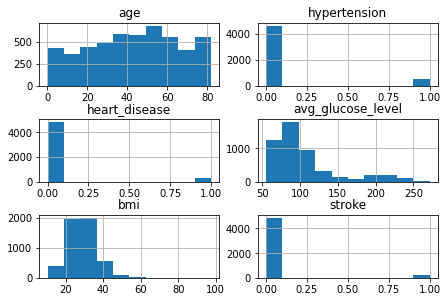

In [ ]:
#Numeric Data統計
df.hist()
plt.tight_layout(False)

In [ ]:
df['work_type'].value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [ ]:
df['Residence_type'].value_counts()

Urban    2596
Rural    2514
Name: Residence_type, dtype: int64

In [ ]:
df['smoking_status'].value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

## 分拆訓練集合、驗證集合、測試集合

In [ ]:
from sklearn.model_selection import train_test_split

y = df['stroke']
X = df.drop(columns=['stroke'])
#Training: 60% Validation: 20% Testing: 20% 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=3)
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=3) 

pd.concat([X_train,y_train],axis=1).head()

,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
1827,Female,60.0,0,0,Yes,Private,Urban,185.31,39.3,never smoked,0
123,Male,56.0,1,0,Yes,Private,Rural,249.31,35.8,never smoked,1
5016,Female,61.0,0,0,Yes,Self-employed,Urban,69.88,27.1,never smoked,0
560,Male,12.0,0,0,No,children,Urban,67.06,16.1,Unknown,0
1940,Female,31.0,0,0,No,Self-employed,Rural,75.27,27.3,never smoked,0


## 分析屬性類別與特徵工程

In [ ]:
from tensorflow import feature_column 
from tensorflow.keras import layers

#先決定要如何處理資料
NUMERIC_COLUMNS     = ['age','avg_glucose_level', 'bmi']
BUCKETIZED_COLUMNS  = [(feature_column.numeric_column('age',dtype=tf.float32),list(np.linspace(0,80,7)))] #把numeric 資料變成區間資料
CATEGORICAL_COLUMNS = ['gender','hypertension','heart_disease','ever_married','work_type','Residence_type','smoking_status']


#產生新型態的模板
feature_columns = []

for feature_name in NUMERIC_COLUMNS:
    feature_columns.append(feature_column.numeric_column(feature_name,dtype=tf.float32))

for (nc,boundaries) in BUCKETIZED_COLUMNS:
    feature_columns.append(feature_column.bucketized_column(nc,boundaries=boundaries))
   
for feature_name in CATEGORICAL_COLUMNS:
    vocabulary = X_train[feature_name].unique()
    one_hot    = feature_column.categorical_column_with_vocabulary_list(feature_name,vocabulary)
    feature_columns.append(feature_column.indicator_column(one_hot))

print(feature_columns)

[NumericColumn(key='age', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='avg_glucose_level', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), NumericColumn(key='bmi', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='gender', vocabulary_list=('Female', 'Male', 'Other'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='hypertension', vocabulary_list=(0, 1), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='heart_disease', vocabulary_list=(0, 1), dtype=tf.int64, default_value=-1, num_oov_buckets=0)), IndicatorColumn(categorical_column=VocabularyListCategoricalColumn(key='ever_married', vocabulary_list=('Yes', 'No'), dtype=tf.string, default_value=-1, num_oov_buckets=0)), Indicato

### 使用tf.data將原資料轉成訓練用的資料

In [ ]:
#定義轉換資料的function
def make_input_fn(X, y, n_epochs=None, shuffle=True):
    def input_fn():
        dataset = tf.data.Dataset.from_tensor_slices((dict(X), y))
        if shuffle:
            dataset = dataset.shuffle(len(y))
        # For training, cycle thru dataset as many times as need (n_epochs=None).
        dataset = dataset.repeat(n_epochs)
        # In memory training doesn't use batching.
        dataset = dataset.batch(len(y))
        return dataset
    return input_fn

#轉換後的資料(給TensorFlow用)
train_input_fn = make_input_fn(X_train, y_train)
valid_input_fn = make_input_fn(X_val, y_val,1) #n_epochs代表重復跑幾次
test_input_fn  = make_input_fn(X_test, y_test,1)


#先把train_input_fn的Ｘ拆出來(給sklearn用)
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)
fc_train_x = feature_layer(dict(X_train)).numpy()
fc_val_x = feature_layer(dict(X_val)).numpy()
fc_test_x  = feature_layer(dict(X_test)).numpy()

# 開始實驗

## TensorFlow 類神經網路

In [ ]:
#宣告輸入層
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

#定義model要幾層和每一層的Activation Function
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation=tf.nn.leaky_relu), #128 = neuron數
  layers.Dense(128, activation=tf.nn.leaky_relu),
  layers.Dense(1, activation='sigmoid')
])

#編譯神經網路
'''
1.optimizer使用adam演算法
2.loss函數為binary_crossentropy
3.accuracy metric 計算how often predictions equal labels
'''
model.compile(optimizer='adam',loss='binary_crossentropy',metrics=['accuracy'])

#開始訓練神經網路
'''
1.epochs：迭代過datasets的次數 == 訓練次數
2.steps_per_epoch：datasets的size / batch size == the number of batch iterations before a training epoch is considered finished
3.validation_steps 類似steps_per_epoch不過是針對validation data
4.verbose：告訴你訓練的進度 0:無 1:進度條 2: ex: Epoch 1/30
'''
model.fit(train_input_fn(),epochs=20,validation_data=valid_input_fn(),steps_per_epoch=10,validation_steps=10,verbose=0)

#訓練結果
results = model.evaluate(test_input_fn(),verbose=0)
print("Loss:",results[0])
print("Accuracy:",results[1])

Loss: 0.15812397003173828
Accuracy: 0.9559686779975891


## TensorFlow BoostedTreesClassifier

In [ ]:
params = {
  'n_trees': 50, #共幾顆樹
  'max_depth': 3, #Tree最大深度
  'n_batches_per_layer': 1, #假設 batch size = len(train_set) 且 n_batches_per_layer = 1 => 每層都會用到一整個dataset
  'center_bias': True #才能得到DFC
}

#宣告分類器
est = tf.estimator.BoostedTreesClassifier(feature_columns,**params)

#訓練分類器
est.train(train_input_fn, max_steps=1000) #max_steps 資料來回幾次, 訓練停止條件

#訓練成果
result = est.evaluate(valid_input_fn)
clear_output()
print(pd.Series(result))

accuracy                  0.954012
accuracy_baseline         0.953033
auc                       0.812115
auc_precision_recall      0.182718
average_loss              0.162403
label/mean                0.046967
loss                      0.162403
precision                 1.000000
prediction/mean           0.049961
recall                    0.020833
global_step             155.000000
dtype: float64


### 檢視Gain-based Importance

In [ ]:
pd.DataFrame({name:[v] for name,v in est.experimental_feature_importances().items()}).T #T == transpose

,0
age,0.238128
bmi,0.112310
avg_glucose_level,0.094942
heart_disease,0.019179
hypertension,0.013684
work_type,0.013677
smoking_status,0.012077
Residence_type,0.009592
gender,0.006504
ever_married,0.000772


### 檢視Directional feature contributions(DFCs)

**檢視訓練樣本整體DFCs**

In [ ]:
pred_dicts = list(est.experimental_predict_with_explanations(make_input_fn(X_train, y_train,1)))

# Create DFC Pandas dataframe.
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])

#abs():把正負的mean都變成正的
#describe():統整資料

df_dfc.abs().describe().T.sort_values(['mean'],ascending=False)

,count,mean,std,min,25%,50%,75%,max
age,3066.0,0.028835,0.024851,4.979039e-05,0.017600,0.025724,0.026709,0.316232
avg_glucose_level,3066.0,0.010597,0.015279,3.981999e-06,0.004813,0.006592,0.008280,0.273310
bmi,3066.0,0.017397,0.029039,2.251894e-04,0.006638,0.008686,0.013500,0.395671
hypertension,3066.0,0.004466,0.006338,2.090750e-04,0.002994,0.003357,0.004177,0.168708
work_type,3066.0,0.002970,0.004885,1.415310e-06,0.001062,0.003058,0.003374,0.158377
smoking_status,3066.0,0.003310,0.005555,3.298904e-05,0.001186,0.002486,0.003051,0.115962
Residence_type,3066.0,0.002818,0.006020,2.018812e-07,0.000026,0.000614,0.002995,0.094964
ever_married,3066.0,0.000183,0.000843,0.000000e+00,0.000000,0.000000,0.000111,0.016530
gender,3066.0,0.000495,0.003591,0.000000e+00,0.000000,0.000000,0.000000,0.094932
heart_disease,3066.0,0.002671,0.011075,0.000000e+00,0.000000,0.000000,0.000830,0.198228


**檢視驗證樣本整體DFCs**

In [ ]:
pred_dicts = list(est.experimental_predict_with_explanations(valid_input_fn))

# Create DFC Pandas dataframe.
df_dfc = pd.DataFrame([pred['dfc'] for pred in pred_dicts])

#abs():把正負的mean都變成正的
#describe():統整資料

df_dfc.abs().describe().T.sort_values(['mean'],ascending=False)

,count,mean,std,min,25%,50%,75%,max
age,1022.0,0.029056,0.025851,9.783441e-05,0.017584,0.026014,0.026770,0.269963
bmi,1022.0,0.017362,0.029755,4.448868e-05,0.006556,0.008695,0.012771,0.268876
avg_glucose_level,1022.0,0.010078,0.013395,1.470623e-05,0.004719,0.006584,0.008200,0.137702
hypertension,1022.0,0.004205,0.005120,2.090750e-04,0.002997,0.003327,0.004071,0.084947
work_type,1022.0,0.003138,0.005264,1.415310e-06,0.001004,0.003060,0.003331,0.096343
smoking_status,1022.0,0.003070,0.004104,1.311613e-05,0.001083,0.002480,0.003014,0.055624
Residence_type,1022.0,0.002992,0.007266,5.509299e-08,0.000016,0.000596,0.002796,0.100538
heart_disease,1022.0,0.002727,0.011503,0.000000e+00,0.000000,0.000000,0.000718,0.156655
gender,1022.0,0.000552,0.003438,0.000000e+00,0.000000,0.000000,0.000000,0.061384
ever_married,1022.0,0.000197,0.001177,0.000000e+00,0.000000,0.000000,0.000098,0.021413


**檢視驗證樣本特定一列的DFCs**

In [ ]:
pd.DataFrame([pred_dicts[2]['dfc']]).abs().T

,0
age,0.035869
bmi,0.015962
avg_glucose_level,0.008474
hypertension,0.003228
work_type,0.001694
smoking_status,0.001295
Residence_type,0.000030
ever_married,0.000000
gender,0.000000
heart_disease,0.000000


## sklearn DecisionTreeClassifier

Decision tree Accuracy: 0.918
Micro-averaged precision score: 0.91
Micro-averaged precision score: 0.91


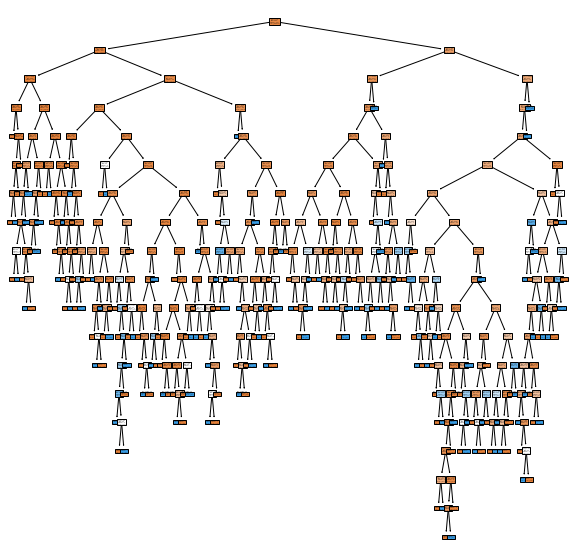

In [ ]:
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.metrics import precision_score, recall_score
from sklearn import tree


#宣告分類器
dt_clf = DecisionTreeClassifier(random_state=42) #random_state 確保每次random的結果一樣

#開始訓練
dt_clf.fit(fc_train_x,y_train)

#訓練成果
dt_acc = dt_clf.score(fc_val_x,y_val)
print('Decision tree Accuracy: {:.3f}'.format(dt_acc))

#計算recall跟precision
y_pred = dt_clf.predict(fc_test_x) #先預測

micro_precision = precision_score(y_pred, y_test, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(micro_precision))

micro_recall = recall_score(y_pred, y_test, average='micro')
print('Micro-averaged precision score: {0:0.2f}'.format(micro_precision))

#呈現樹的分類方式

#樹的文字圖
#text_representation = tree.export_text(dt_clf)
#print(text_representation)

#樹的視覺圖
plt.figure(figsize=(10,10))
a=plot_tree(dt_clf, filled=True)
plt.savefig('decision_tree.pdf')


### 檢視Gain-based Importance

In [ ]:
pd.DataFrame({name:[cr] for cr,name  in zip(dt_clf.feature_importances_,X_train.columns)}).T.sort_values([0],ascending=False)  

,0
heart_disease,0.269943
ever_married,0.227611
hypertension,0.216231
avg_glucose_level,0.027607
age,0.022867
bmi,0.019408
gender,0.017785
work_type,0.013508
Residence_type,0.010050
smoking_status,0.000000


### 檢視Directional feature contributions(DFCs)

**檢視訓練樣本整體DFCs**

In [ ]:
prediction, bias, contributions = ti.predict(dt_clf, fc_train_x)
contrib = []
for p, b, c in zip(prediction, bias, contributions):
    class_id = np.argmax(p)
    contrib.append(np.abs(np.array(c)[:,class_id].ravel()))

pd.DataFrame({name:[cr] for name, cr in zip(X_train.columns, np.mean(np.array(contrib),axis=0))}).head().T.sort_values([0],ascending=False)

,0
hypertension,0.061311
heart_disease,0.038159
ever_married,0.037585
age,0.005558
avg_glucose_level,0.005304
bmi,0.005294
gender,0.002316
work_type,0.001305
Residence_type,0.001223
smoking_status,0.000000


## sklearn RandomForestClassifier

In [ ]:
from sklearn.ensemble import RandomForestClassifier

#宣告分類器
rf_clf = RandomForestClassifier(random_state=42)

#開始訓練
rf_clf.fit(fc_train_x,y_train)

#訓練成果
rf_acc = rf_clf.score(fc_test_x,y_test)
print('Random Forest accuracy: {:.3f}'.format(rf_acc))

Random forest accuracy: 0.952


## sklearn BoostedTreesClassifier




In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

#宣告分類器
bt_clf = GradientBoostingClassifier(learning_rate = 0.02, random_state=42)

#開始訓練
bt_clf.fit(fc_train_x,y_train)

#訓練成果
bt_acc = bt_clf.score(fc_test_x,y_test)
print('Boosted Trees accuracy: {:.3f}'.format(bt_acc))

Boosted Trees accuracy: 0.951


## sklearn KNNClassifier

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV #使用k-fold CV 並找出最佳的k

#宣告分類器
knn = KNeighborsClassifier()

#為分類器加上CV並設定參數
param_grid = {'n_neighbors': np.arange(1, 5)}
knn_gscv = GridSearchCV(knn, param_grid, cv=10) #用Gridsearch去測試所有n_neighbors的值

#開始訓練
knn_gscv.fit(fc_train_x,y_train)

#找出最好的Ｋ
print('Best K:',knn_gscv.best_params_)
print('Best Score:',knn_gscv.best_score_)
#plt.plot(knn_gscv.cv_results_['param_n_neighbors'].data, knn_gscv.cv_results_['mean_test_score'])

#使用最好的k去訓練分類器並進行測試
knn_final = KNeighborsClassifier(n_neighbors=knn_gscv.best_params_['n_neighbors'])
knn_final.fit(fc_train_x,y_train)

knn_acc = knn_final.score(fc_test_x, y_test)
print('KNNClassifier accuracy: {:.3f}'.format(knn_acc))

Best K: {'n_neighbors': 8}
Best Score: 0.9484692682719125
KNNClassifier accuracy: 0.955
